In [2]:
import os
import pandas as pd

qa_file_name = 'gpt-4o-batch-all-target_extract_gpt-4o-QAExtractor-batch_pid_0.jsonl.csv'
qa_dataset_path = os.path.join(os.path.abspath('../../.cache'), qa_file_name)
df = pd.read_csv(qa_dataset_path)

In [3]:
import json

def get_context(input_text):
    lines = input_text.split('\n')
    for idx, text in enumerate(lines):
        if text.startswith('Here is the context'):
            # The next line will be the context string
            if idx + 1 < len(lines):
                return lines[idx + 1]

def get_quetions_answers_and_groundtruth(df):
    questions = []
    ground_truths = []
    correct_contexts = []

    for row_id, obj_str in enumerate(df['objs']):
        objs = json.loads(obj_str)
        if len(objs) == 0:
            print(f"[Invalid rqa pairs] No objs found at row id: {row_id} which should have {df['qar_num'][row_id]} questions")
        for obj in objs:
            questions.append(obj['Question'])
            ground_truths.append(obj['Answer'])
            correct_contexts.append([get_context(df['input_text'][row_id])])
    return questions, ground_truths, correct_contexts

q, g, c = get_quetions_answers_and_groundtruth(df)

[Invalid rqa pairs] No objs found at row id: 10 which should have 3 questions
[Invalid rqa pairs] No objs found at row id: 126 which should have 1 questions
[Invalid rqa pairs] No objs found at row id: 195 which should have 1 questions
[Invalid rqa pairs] No objs found at row id: 415 which should have 1 questions
[Invalid rqa pairs] No objs found at row id: 457 which should have 1 questions
[Invalid rqa pairs] No objs found at row id: 556 which should have 1 questions
[Invalid rqa pairs] No objs found at row id: 561 which should have 1 questions
[Invalid rqa pairs] No objs found at row id: 574 which should have 1 questions
[Invalid rqa pairs] No objs found at row id: 579 which should have 1 questions
[Invalid rqa pairs] No objs found at row id: 631 which should have 1 questions
[Invalid rqa pairs] No objs found at row id: 641 which should have 1 questions
[Invalid rqa pairs] No objs found at row id: 709 which should have 1 questions


In [1]:
import os
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model = AutoModelForSequenceClassification.from_pretrained(os.path.abspath('../step_3_level_predictor/results/checkpoint-945'))
tokenizer = AutoTokenizer.from_pretrained(os.path.abspath('../step_3_level_predictor/results/checkpoint-945'))

In [2]:
import torch

# Example input text
input_text = "This is an example sentence."

# Tokenize the input
inputs = tokenizer(input_text, return_tensors="pt", truncation=True)

# Put the model in evaluation mode
model.eval()

# Get the prediction
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=-1)

print(f"Predicted class: {predicted_class.item()}")

Predicted class: 2


In [7]:
import json
import pandas as pd

file_path = "./dataset/gpt-4o-batch-all-target_with_predictor_retrieved_contexts_dataset_condition_2.jsonl"

# Read the JSONL file line by line and convert it into a list of dictionaries
data = []
with open(file_path, 'r') as file:
    for line in file:
        data.append(json.loads(line.strip()))  # Parse each line as JSON and add it to the list

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(data)

# Add a new column for the sum of the lengths of the 'context' field
df['context_length_sum'] = df['context'].apply(lambda context: sum(len(text) for text in context))

# Display the updated DataFrame
df.head()

,question,ground_truth,answer,context,context_length_sum
0,What structural factor allows for easy water a...,Cracked cuticles allow for easy water absorpti...,Cracked cuticles in soybean cultivars allow fo...,[This research investigates the differences in...,1475
1,Why do intact cuticles remain impermeable to w...,Intact cuticles remain impermeable due to the ...,Intact cuticles remain impermeable to water du...,[What components of the intact outer cuticle a...,708
2,How can the permeability of intact cuticles be...,Heat and alkaline treatments can temporarily r...,The permeability of intact cuticles can be tem...,[What components of the intact outer cuticle a...,1660
3,Why has the production of healthy sweeteners l...,The production of healthy sweeteners like fruc...,The production of healthy sweeteners like fruc...,[The production of healthy sweeteners like fru...,856
4,What are the methods mentioned for producing f...,Fructose can be made using either multi-enzyma...,Fructose can be produced using multi-enzymatic...,[Monosaccharides can be generated through vari...,1017


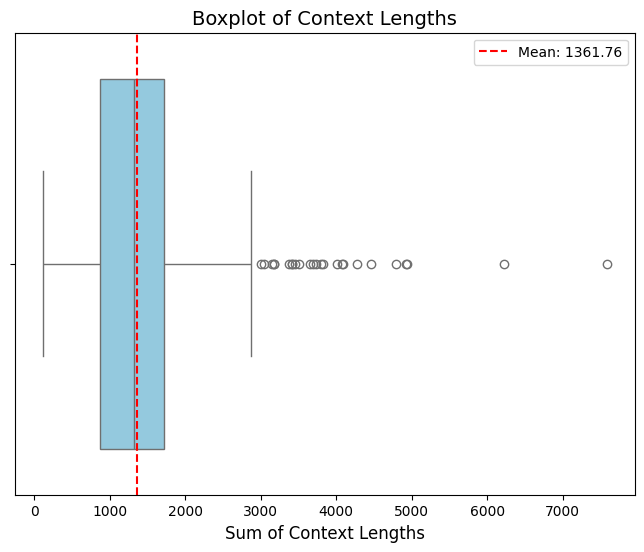

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

mean_length = df['context_length_sum'].mean()

# Plot the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['context_length_sum'], color="skyblue")

# Display the mean value as a vertical line
plt.axvline(mean_length, color='red', linestyle='--', label=f'Mean: {mean_length:.2f}')

# Add titles and labels
plt.title("Boxplot of Context Lengths", fontsize=14)
plt.xlabel("Sum of Context Lengths", fontsize=12)
plt.legend()

# Show the plot
plt.show()

In [1]:
import json
import pandas as pd

file_path = "./datasets/gpt-4o-batch-all-target_one_retrieved_contexts_dataset_condition_1.jsonl"

# Read the JSONL file line by line and convert it into a list of dictionaries
retrieved_nums = []
contexts_length = []
groundtruth_position = []
with open(file_path, 'r') as file:
    for line in file:
        data = json.loads(line.strip())  # Parse each line as JSON and add it to the list
        retrieved_nums.append(len(data['contexts']))
        contexts_length.append(sum([len(text) for text in data['contexts']]))
        groundtruth_position.append(
            data['contexts'].index(data['ground_truth']) 
            if data['ground_truth'] in data['contexts'] 
            else -1
        )

In [3]:
import os
import pandas as pd

dir_path = r'..\step_5_evluation_score\score'
correctness_file = r'gpt-4o-batch-all-target_one_retrieved_contexts_dataset_condition_2_answer_correctness_2024-12-20-08-42-45.csv'
# print(os.path.exists())
result = pd.read_csv(os.path.join(dir_path, correctness_file))
assert len(groundtruth_position) == len(result), "Mismatched lengths between datasets!"
result['contexts_length'] = contexts_length
result['groundtruth_position'] = groundtruth_position
    

FileNotFoundError: [Errno 2] No such file or directory: '..\\step_5_evluation_score\\score\\gpt-4o-batch-all-target_one_retrieved_contexts_dataset_condition_2_answer_correctness_2024-12-20-08-42-45.csv'

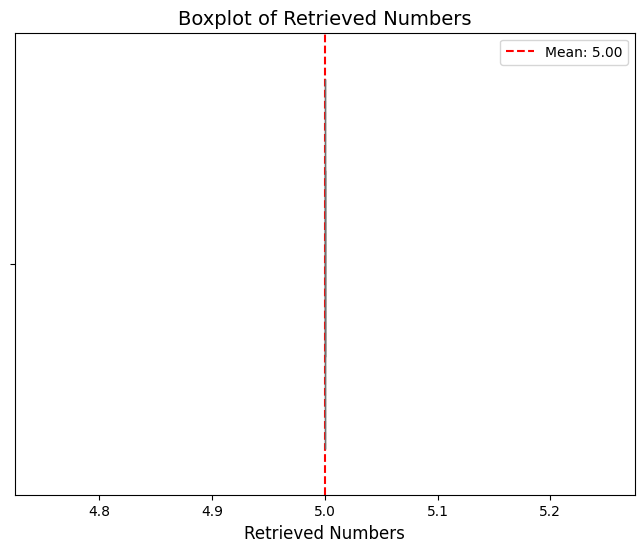

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

mean_length = sum(retrieved_nums)/len(retrieved_nums)

# Plot the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x=retrieved_nums, color="skyblue")

# Display the mean value as a vertical line
plt.axvline(mean_length, color='red', linestyle='--', label=f'Mean: {mean_length:.2f}')

# Add titles and labels
plt.title("Boxplot of Retrieved Numbers", fontsize=14)
plt.xlabel("Retrieved Numbers", fontsize=12)
plt.legend()

# Show the plot
plt.show()

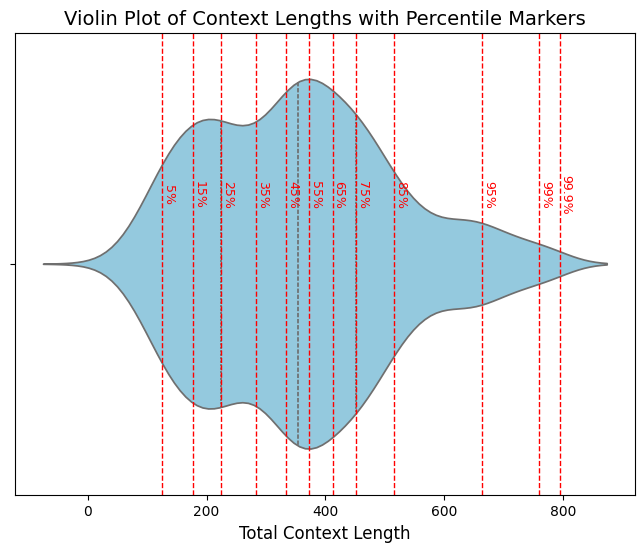

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate percentiles
percentages = [5, 15, 25, 35, 45, 55, 65, 75, 85, 95, 99, 99.9]
percentiles = np.percentile(contexts_length, percentages)

# Plot the violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(
    x=contexts_length, 
    color="skyblue", 
    inner="quartile"
)

# Add percentile markers and annotations
for perc, label in zip(percentiles, percentages):
    plt.axvline(perc, color='red', linestyle='--', linewidth=1)
    plt.text(
        perc, 
        -0.15,  # Y-coordinate for the text
        f'{label}%', 
        color='red', 
        rotation=270, 
        verticalalignment='center',
        fontsize=9
    )

# Add titles and labels
plt.title("Violin Plot of Context Lengths with Percentile Markers", fontsize=14)
plt.xlabel("Total Context Length", fontsize=12)

# Show the plot
plt.show()

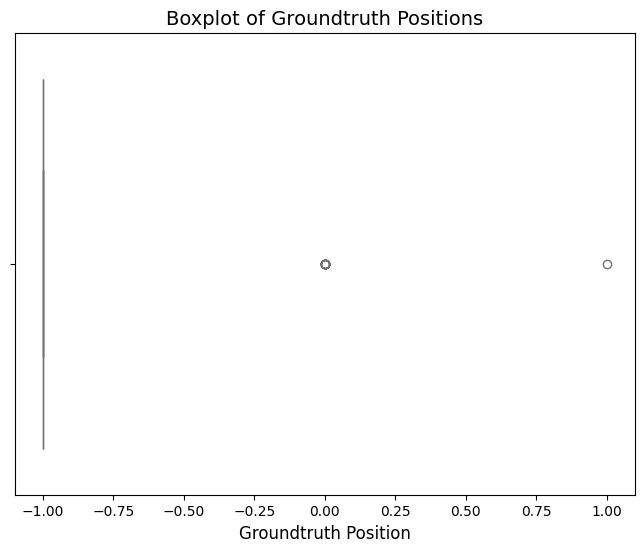

In [55]:
# 2. Boxplot of Groundtruth Position
plt.figure(figsize=(8, 6))
sns.boxplot(x=result['groundtruth_position'], color="lightgreen")
plt.title("Boxplot of Groundtruth Positions", fontsize=14)
plt.xlabel("Groundtruth Position", fontsize=12)
plt.show()

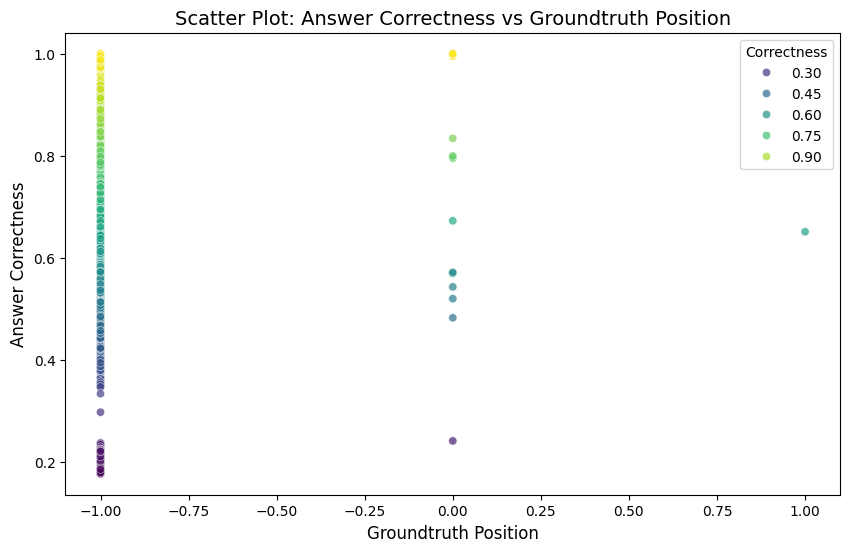

In [56]:
# 3. Scatter Plot: Answer Correctness vs Groundtruth Position
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='groundtruth_position', 
    y='answer_correctness', 
    data=result, 
    alpha=0.7, 
    hue='answer_correctness', 
    palette='viridis'
)
plt.title("Scatter Plot: Answer Correctness vs Groundtruth Position", fontsize=14)
plt.xlabel("Groundtruth Position", fontsize=12)
plt.ylabel("Answer Correctness", fontsize=12)
plt.legend(title="Correctness", loc='upper right')
plt.show()

In [75]:
sum(result['groundtruth_position'] == -1)/len(result['groundtruth_position'])

0.9847942754919499

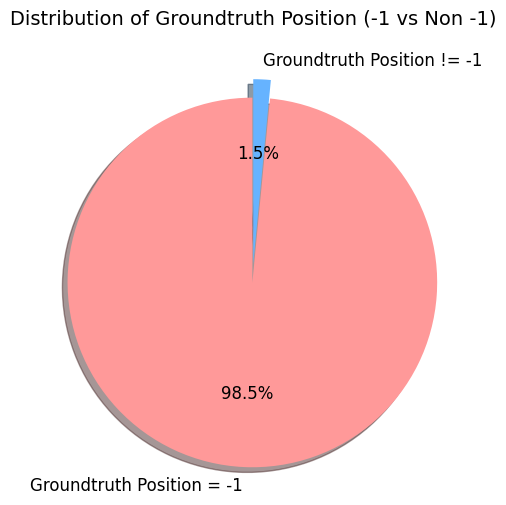

In [77]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the count of groundtruth_position == -1 and != -1
count_neg1 = (result['groundtruth_position'] == -1).sum()
count_non_neg1 = (result['groundtruth_position'] != -1).sum()

# Data for pie chart (counts)
labels = ['Groundtruth Position = -1', 'Groundtruth Position != -1']
sizes = [count_neg1, count_non_neg1]
colors = ['#ff9999', '#66b3ff']  # Red for -1, Blue for non -1
explode = (0.1, 0)  # "explode" the first slice for emphasis

# Plot the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, shadow=True, textprops={'fontsize': 12})

# Equal aspect ratio ensures that pie chart is drawn as a circle.
plt.title("Distribution of Groundtruth Position (-1 vs Non -1)", fontsize=14)
plt.show()

